# Actor Critic Project

## Setup

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import cast
#import pandas as pd
#import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import collections
import gymnasium as gym
import itertools
import numpy as np

# from numpy.typing import NDArray
import pandas as pd
from pathlib import Path
import random
import torch
from typing import Callable, cast, List, Tuple, Union
%matplotlib inline

import matplotlib.pyplot as plt

import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import Video

from ipywidgets import interact
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
sns.set_context("talk")
FIGS_DIR = Path("figs/") / "lab6"       # Where to save figures (.gif or .mp4 files)
PLOTS_DIR = Path("figs/") / "lab6"      # Where to save plots (.png or .svg files)
MODELS_DIR = Path("models/") / "lab6"   # Where to save models (.pth files)
if not FIGS_DIR.exists():
    FIGS_DIR.mkdir(parents=True)
if not PLOTS_DIR.exists():
    PLOTS_DIR.mkdir(parents=True)
if not MODELS_DIR.exists():
    MODELS_DIR.mkdir(parents=True)

# Set random seed for reproducibility
seed = 23
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
print(device)
#device = 'cpu'

mps


In [3]:
########## TO BE ABLE TO RUN AND VISUALIZE EPISODE GIVEN AN AGENT #############

from IPython.display import Video
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from pathlib import Path


def run_and_display_episode(agent, env_name="CartPole-v1", video_title="vid-name"):
    """
    Run an episode with the given agent and display it as a video.
    
    Args:
        agent: Trained ActorCriticNetwork instance
        env_name: Gymnasium environment name (default: "CartPole-v1")
        video_title: Prefix for the video file name (default: "vid-name")
        max_steps: Maximum steps to run the episode (default: 500)
    """
    # Set up video directory
    VIDS_DIR = Path("./videos")
    VIDS_DIR.mkdir(parents=True, exist_ok=True)  # Simplified directory creation

    # Define video path
    video_filename = f"{video_title}-episode-0.mp4"
    video_path = VIDS_DIR / video_filename
    video_path.unlink(missing_ok=True)  # Clean up any existing file

    # Create and wrap environment
    env = gym.make(env_name, render_mode="rgb_array")
    env = RecordVideo(
        env,
        video_folder=str(VIDS_DIR),
        name_prefix=video_title,
        episode_trigger=lambda x: x == 0  # Record only first episode
    )

    # Run episode
    state, info = env.reset()
    done = False
    step = 0
    while not done:
        action = agent.policy(state)[0]  # Unpack tuple explicitly
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        step += 1
    
    # Finalize and display
    env.close()
    print(f"Episode ran for {step} steps")  # Confirm length
    display(Video(
        str(video_path),
        embed=True,
        html_attributes="controls autoplay loop"
    ))

## Continuous State Space + Discrete Action Space

In [4]:
gymnasium_environments = [
    # (env_name, max_reward)
    ("CartPole-v1", 500),#worst possible is close to 0 (positive)
    ("MountainCar-v0", 0), #worst possible is -200
    ("Acrobot-v1", 0)#worst possible -500
]

## Libraires


In [5]:
#def video_selector(file_path: List[Path]):
#    return Video(file_path, embed=True, html_attributes="controls autoplay loop")

In [6]:

#DEFAULT_NUMBER_OF_TRAININGS = 3


## Env Setup

In [7]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

cartpole_observation_space = cast(gym.spaces.Box, env.observation_space)
cartpole_action_space = cast(gym.spaces.Discrete, env.action_space)

cartpole_observation_dim = cartpole_observation_space.shape[0]  # Number of *dimensions* in the observation space (i.e. number of *elements* in the observation vector)
cartpole_num_actions = cartpole_action_space.n.item()           # Number of possible actions

print(f"State space size is: {cartpole_observation_space}")
print(f"Action space size is: {cartpole_action_space}")
print("Actions are: {" + ", ".join([str(a) for a in range(cartpole_action_space.n)]) + "}")

env.close()

State space size is: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action space size is: Discrete(2)
Actions are: {0, 1}


## Basic Actor Critic using MC 


In [ ]:
class QNetwork(torch.nn.Module):
    """
    A Q-Network implemented with PyTorch.

    Attributes
    ----------
    layer1 : torch.nn.Linear
        First fully connected layer.
    layer2 : torch.nn.Linear
        Second fully connected layer.
    layer3 : torch.nn.Linear
        Third fully connected layer.

    Methods
    -------
    forward(x: torch.Tensor) -> torch.Tensor
        Define the forward pass of the QNetwork.
    """

    def __init__(self, n_observations: int, n_actions: int, nn_l1: int, nn_l2: int):
        """
        Initialize a new instance of QNetwork.

        Parameters
        ----------
        n_observations : int
            The size of the observation space.
        n_actions : int
            The size of the action space.
        nn_l1 : int
            The number of neurons on the first layer.
        nn_l2 : int
            The number of neurons on the second layer.
        """
        super(QNetwork, self).__init__()
        self.layer1 = torch.nn.Linear(n_observations, nn_l1)
        self.layer2 = torch.nn.Linear(nn_l1, nn_l2)
        self.layer3 = torch.nn.Linear(nn_l2, n_actions)
        self.n_actions = n_actions
        self.n_observations =n_observations
        self.relu = torch.nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Define the forward pass of the QNetwork.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor (state).

        Returns
        -------
        torch.Tensor
            The output tensor (Q-values).
        """
        x = self.layer1(x)
        x= self.relu(x)
        x = self.layer2(x)
        x= self.relu(x)
        x = self.layer3(x)
        return x
    

class PolicyNetwork(torch.nn.Module):
    """
    A neural network used as a policy for the REINFORCE algorithm.

    Attributes
    ----------
    layer1 : torch.nn.Linear
        A fully connected layer.

    Methods
    -------
    forward(state: torch.Tensor) -> torch.Tensor
        Define the forward pass of the PolicyNetwork.
    """

    def __init__(self, n_observations: int, n_actions: int):
        """
        Initialize a new instance of PolicyNetwork.

        Parameters
        ----------
        n_observations : int
            The size of the observation space.
        n_actions : int
            The size of the action space.
        """
        super(PolicyNetwork, self).__init__()
        self.layer1 = torch.nn.Linear(n_observations, n_actions, bias=False)

    def forward(self, state_tensor: torch.Tensor) -> torch.Tensor:
        """
        Calculate the probability of each action for the given state.

        Parameters
        ----------
        state_tensor : torch.Tensor
            The input tensor (state).
            The shape of the tensor should be (N, dim),
            where N is the number of states vectors in the batch
            and dim is the dimension of state vectors.

        Returns
        -------
        torch.Tensor
            The output tensor (the probability of each action for the given state).
        """
        state_tensor = state_tensor.to(device)


        x = self.layer1(state_tensor)
        out = torch.nn.functional.softmax(x, dim=1)
        return out

In [15]:
def sample_discrete_action(
    policy_nn, state: np.ndarray
) -> Tuple[int, torch.Tensor]:
    """
    Sample a discrete action based on the given state and policy network.

    This function takes a state and a policy network, and returns a sampled action and its log probability.
    The action is sampled from a categorical distribution defined by the output of the policy network.

    Parameters
    ----------
    policy_nn : PolicyNetwork
        The policy network that defines the probability distribution of the actions.
    state : np.ndarray
        The state based on which an action needs to be sampled.

    Returns
    -------
    Tuple[int, torch.Tensor]
        The sampled action and its log probability.

    """
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    actions_probability_distribution_params = policy_nn(state_tensor)
    actions_probability_distribution = torch.distributions.categorical.Categorical(actions_probability_distribution_params)
    sampled_action_tensor = actions_probability_distribution.sample()
    sampled_action = sampled_action_tensor.item()
    sampled_action_log_probability = actions_probability_distribution . log_prob(sampled_action_tensor)
    return sampled_action, sampled_action_log_probability
def sample_one_episode(
    env: gym.Env, policy_nn, max_episode_duration: int
) -> Tuple[List[np.ndarray], List[int], List[float], List[torch.Tensor]]:
    """
    Execute one episode within the `env` environment utilizing the policy defined by the `policy_nn` parameter.

    Parameters
    ----------
    env : gym.Env
        The environment to play in.
    policy_nn : PolicyNetwork
        The policy neural network.
    max_episode_duration : int
        The maximum duration of the episode.


    Returns
    -------
    Tuple[List[np.ndarray], List[int], List[float], List[torch.Tensor]]
        The states, actions, rewards, and log probability of action for each time step in the episode.
    """
    state_t, info = env.reset()

    episode_states = []
    episode_actions = []
    episode_log_prob_actions = []
    episode_rewards = []
    episode_states.append(state_t)

    for t in range(max_episode_duration):

        # Sample a discrete action and its log probability from the policy network based on the current state
        # action_t, log_prob_action_t = TODO...
        action_t, log_prob_action_t = sample_discrete_action(policy_nn, state_t)
        # Execute the sampled action in the environment, which returns the new state, reward, and whether the episode has terminated or been truncated
        # state_t, reward_t, terminated, truncated, info = TODO...
        state_t, reward_t, terminated, truncated, info = env.step(action_t)
        # Check if the episode is done, either due to termination (reaching a terminal state) or truncation (reaching a maximum number of steps)
        done = terminated or truncated

        # Append the new state, action, action log probability and reward to their respective lists

        episode_states.append(state_t)
        episode_actions.append(action_t)
        episode_log_prob_actions.append(log_prob_action_t)
        episode_rewards.append(float(reward_t))

        if done:
            break

    return episode_states, episode_actions, episode_rewards, episode_log_prob_actions


def avg_return_on_multiple_episodes(
    env: gym.Env,
    policy_nn,
    num_test_episode: int,
    max_episode_duration: int,
) -> float:
    """
    Play multiple episodes of the environment and calculate the average return.

    Parameters
    ----------
    env : gym.Env
        The environment to play in.
    policy_nn : PolicyNetwork
        The policy neural network.
    num_test_episode : int
        The number of episodes to play.
    max_episode_duration : int
        The maximum duration of an episode.
    Returns
    -------
    float
        The average return.
    """
    return np.mean([sum(sample_one_episode(env, policy_nn, max_episode_duration)[2]) for _ in range(num_test_episode)])

In [ ]:
def train_basic_ac(
    env: gym.Env,
    num_train_episodes: int,
    num_test_per_episode: int,
    max_episode_duration: int,
    q_learning_rate: float,
    p_learning_rate: float,
    nn_l1: int, 
    nn_l2: int,
    ):
    """
    Train a policy using the REINFORCE algorithm.

    Parameters
    ----------
    env : gym.Env
        The environment to train in.
    num_train_episodes : int
        The number of training episodes.
    num_test_per_episode : int
        The number of tests to perform per episode.
    max_episode_duration : int
        The maximum length of an episode, by default EPISODE_DURATION.
    learning_rate : float
        The initial step size.
    gamma : float
        The discount factor for future rewards.
    Returns
    -------
    PolicyNetwork, QNetwork
        The final trained policy and the average returns for each episode.
    """
    policy_rewards = []
    q_loss_list = []
    q_network = QNetwork(cartpole_observation_dim, cartpole_num_actions, nn_l1, nn_l2).to(device)
    policy_nn = PolicyNetwork(cartpole_observation_dim, cartpole_num_actions).to(device)
    p_optimizer = torch.optim.Adam(policy_nn.parameters(), lr=p_learning_rate)
    q_optimizer = torch.optim.Adam(q_network.parameters(), lr=q_learning_rate)

    for episode_index in tqdm(range(num_train_episodes)):
        episode_states, episode_actions, episode_rewards, episode_log_prob_actions = sample_one_episode(env, policy_nn, max_episode_duration)

        predicted_q_values = q_network(torch.tensor(episode_states, dtype=torch.float32))
        predicted_q_values = predicted_q_values[range(len(episode_actions)), episode_actions]

        q_loss = torch.mean((predicted_q_values - sum(episode_rewards))**2)
        q_loss_list.append(q_loss.item())
        q_optimizer.zero_grad()
        q_loss.backward()
        q_optimizer.step()
        running_reward = 0
        for i, lp in enumerate(episode_log_prob_actions):
            p_optimizer.zero_grad()
            p_loss = -lp * sum (predicted_q_values[i:].detach())
            p_loss.backward()
            p_optimizer.step()
            running_reward += episode_rewards[i]

        test_avg_return = avg_return_on_multiple_episodes(
            env=env,
            policy_nn=policy_nn,
            num_test_episode=num_test_per_episode,
            max_episode_duration=max_episode_duration,
        )
        policy_rewards.append(test_avg_return)



    return policy_nn, q_network, policy_rewards, q_loss_list

In [ ]:
env = gym.make("CartPole-v1")

pol, qn, pl, ql = train_basic_ac(
    env=env,
    num_train_episodes=500,
    num_test_per_episode=5,
    max_episode_duration=750,
    p_learning_rate=0.01,
    q_learning_rate=0.01,
    nn_l1=128,
    nn_l2=128,
)

env.close()

In [ ]:
plt.plot(pl)
plt.title('Average Return')
plt.show()

In [ ]:
VIDEO_PREFIX_EX1_LEFT = "ac_cartpole_MC"

(FIGS_DIR / f"{VIDEO_PREFIX_EX1_LEFT}-episode-0.mp4").unlink(missing_ok=True)

env = gym.make("CartPole-v1", render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, video_folder=str(FIGS_DIR), name_prefix=VIDEO_PREFIX_EX1_LEFT)

observation, info = env.reset()
done = False
while not done:
    action = pol(torch.tensor(observation, dtype=torch.float32).unsqueeze(0)).argmax().item()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

env.close()

Video(
    FIGS_DIR / f"{VIDEO_PREFIX_EX1_LEFT}-episode-0.mp4",
    embed=True,
    html_attributes="controls autoplay loop",
)



## A2C 

In [ ]:
class ValueNetwork(torch.nn.Module):
    def __init__(self, n_observations, nn_l1=128, nn_l2=128):
        super(ValueNetwork, self).__init__()
        self.layer1 = torch.nn.Linear(n_observations, nn_l1)
        self.layer2 = torch.nn.Linear(nn_l1, nn_l2)
        self.layer3 = torch.nn.Linear(nn_l2, 1)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        return self.layer3(x)

In [ ]:
def train_a2c(
    env: gym.Env,
    num_train_episodes: int,
    num_test_per_episode: int,
    max_episode_duration: int,
    gamma: float,
    v_learning_rate: float,
    p_learning_rate: float
    ):

    policy_nn = PolicyNetwork(cartpole_observation_dim, cartpole_num_actions).to(device)
    value_nn = ValueNetwork(cartpole_observation_dim).to(device)
    
    p_optimizer = torch.optim.Adam(policy_nn.parameters(), lr=p_learning_rate)
    v_optimizer = torch.optim.Adam(value_nn.parameters(), lr=v_learning_rate)
    policy_rewards = []
    for episode_index in tqdm(range(num_train_episodes)):
        episode_states, episode_actions, episode_rewards, episode_log_prob_actions = sample_one_episode(env, policy_nn, max_episode_duration)
        
        discounted_returns = []
        R = 0
        for r in reversed(episode_rewards):
            R = r + gamma * R
            discounted_returns.insert(0, R)
        
        state_tensors = torch.tensor(episode_states[:-1], dtype=torch.float32)
        predicted_values = value_nn(state_tensors).squeeze()
        
        v_targets = torch.tensor(discounted_returns, dtype=torch.float32)  
        v_loss = torch.nn.functional.mse_loss(predicted_values, v_targets)
        
        v_optimizer.zero_grad()
        v_loss.backward()
        v_optimizer.step()

        
        for i, lp in enumerate(episode_log_prob_actions):            
            if i < len(episode_states) - 2:  
                # advantage = Q(a,s) - V(s) = r + gamma * V(s') - V(s)
                advantage = episode_rewards[i] + gamma * predicted_values[i+1].detach() - predicted_values[i].detach()
                
                p_optimizer.zero_grad()
                p_loss = -lp * advantage 
                p_loss.backward()
                p_optimizer.step()

        test_avg_return = avg_return_on_multiple_episodes(
            env=env,
            policy_nn=policy_nn,
            num_test_episode=num_test_per_episode,
            max_episode_duration=max_episode_duration,
        )
        policy_rewards.append(test_avg_return)

    


    return policy_nn, value_nn  , policy_rewards #, q_loss_list

In [ ]:
pol, vn, pl = train_a2c(
    env=env,
    num_train_episodes=500,
    num_test_per_episode=5,
    max_episode_duration=750,
    p_learning_rate=0.01,
    v_learning_rate=0.01,
    gamma=1
)

In [ ]:
plt.plot(pl)
plt.title('Average Return')
plt.show()

In [ ]:
VIDEO_PREFIX_EX1_LEFT = "ac_cartpole_A2C"

(FIGS_DIR / f"{VIDEO_PREFIX_EX1_LEFT}-episode-0.mp4").unlink(missing_ok=True)

env = gym.make("CartPole-v1", render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, video_folder=str(FIGS_DIR), name_prefix=VIDEO_PREFIX_EX1_LEFT)

observation, info = env.reset()
done = False
while not done:
    action = pol(torch.tensor(observation, dtype=torch.float32).unsqueeze(0)).argmax().item()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

env.close()

Video(
    FIGS_DIR / f"{VIDEO_PREFIX_EX1_LEFT}-episode-0.mp4",
    embed=True,
    html_attributes="controls autoplay loop",
)



## Improved A2C using GAE and MinimumExponentialLR

In [ ]:
class MinimumExponentialLR(torch.optim.lr_scheduler.ExponentialLR):
    def __init__(
        self,
        optimizer: torch.optim.Optimizer,
        lr_decay: float,
        last_epoch: int = -1,
        min_lr: float = 1e-6,
    ):
        """
        Initialize a new instance of MinimumExponentialLR.

        Parameters
        ----------
        optimizer : torch.optim.Optimizer
            The optimizer whose learning rate should be scheduled.
        lr_decay : float
            The multiplicative factor of learning rate decay.
        last_epoch : int, optional
            The index of the last epoch. Default is -1.
        min_lr : float, optional
            The minimum learning rate. Default is 1e-6.
        """
        self.min_lr = min_lr
        super().__init__(optimizer, lr_decay, last_epoch=-1)

    def get_lr(self) -> List[float]:
        """
        Compute learning rate using chainable form of the scheduler.

        Returns
        -------
        List[float]
            The learning rates of each parameter group.
        """
        return [
            max(base_lr * self.gamma**self.last_epoch, self.min_lr)
            for base_lr in self.base_lrs
        ]

In [ ]:
def gae(rewards, values, next_value, done, gamma, lam):
    advantages = []
    gae = 0
    
    for t in reversed(range(len(rewards))):
        if t == len(rewards) - 1:
            next_val = next_value
        else:
            next_val = values[t + 1]
            
        delta = rewards[t] + gamma * next_val * (1 - done[t]) - values[t]
        gae = delta + gamma * lam * (1 - done[t]) * gae
        advantages.insert(0, gae)
        
    return advantages

In [ ]:
def train_ac_gae(
    env: gym.Env,
    num_train_episodes: int,
    num_test_per_episode: int,
    max_episode_duration: int,
    gamma: float,
    ):

    policy_nn = PolicyNetwork(cartpole_observation_dim, cartpole_num_actions).to(device)
    value_nn = ValueNetwork(cartpole_observation_dim).to(device)
    
    p_optimizer = torch.optim.Adam(policy_nn.parameters(), lr=0.01)

    v_optimizer = torch.optim.Adam(value_nn.parameters(), lr=0.01)
    v_lr_scheduler = MinimumExponentialLR(v_optimizer, lr_decay=0.99, min_lr=1e-6)


    policy_rewards = []
    for episode_index in tqdm(range(num_train_episodes)):
        episode_states, episode_actions, episode_rewards, episode_log_prob_actions = sample_one_episode(env, policy_nn, max_episode_duration)
        
        discounted_returns = []
        R = 0
        for r in reversed(episode_rewards):
            R = r + gamma * R
            discounted_returns.insert(0, R)
        
        state_tensors = torch.tensor(episode_states[:-1], dtype=torch.float32)
        predicted_values = value_nn(state_tensors).squeeze()
        
        v_targets = torch.tensor(discounted_returns, dtype=torch.float32)  
        v_loss = torch.nn.functional.mse_loss(predicted_values, v_targets)
        
        v_optimizer.zero_grad()
        v_loss.backward()
        v_optimizer.step()
        v_lr_scheduler.step()

        with torch.no_grad():
            next_state = episode_states[-1]
            next_value = value_nn(torch.tensor([next_state], dtype=torch.float32)).item() if not done else 0
            
        values = predicted_values.detach().numpy()
        dones = [0] * (len(episode_rewards) - 1) + [1]  
        advantages = gae(episode_rewards, values, next_value, dones, gamma=0.99, lam=0.95)
        advantages = torch.tensor(advantages, dtype=torch.float32)

        
        for i, lp in enumerate(episode_log_prob_actions):            
            if i < len(episode_states) - 2:  #
                # advantage = Q(a,s) - V(s) = r + gamma * V(s') - V(s)
                p_optimizer.zero_grad()
                p_loss = -lp * advantages[i]  # Policy gradient with advantage
                p_loss.backward()
                p_optimizer.step()



        test_avg_return = avg_return_on_multiple_episodes(
            env=env,
            policy_nn=policy_nn,
            num_test_episode=num_test_per_episode,
            max_episode_duration=max_episode_duration,
        )
        policy_rewards.append(test_avg_return)

    


    return policy_nn, value_nn  , policy_rewards #, q_loss_list

In [ ]:
pol, vn, pl = train_ac_gae(
    env=env,
    num_train_episodes=500,
    num_test_per_episode=5,
    max_episode_duration=1000,
    gamma=0.99,
)

In [ ]:
plt.plot(pl)
plt.title('Average Return')
plt.show()

In [ ]:
VIDEO_PREFIX_EX1_LEFT = "ac_cartpole_ACGAE"

(FIGS_DIR / f"{VIDEO_PREFIX_EX1_LEFT}-episode-0.mp4").unlink(missing_ok=True)

env = gym.make("CartPole-v1", render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, video_folder=str(FIGS_DIR), name_prefix=VIDEO_PREFIX_EX1_LEFT)

observation, info = env.reset()
done = False
while not done:
    action = pol(torch.tensor(observation, dtype=torch.float32).unsqueeze(0)).argmax().item()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

env.close()

Video(
    FIGS_DIR / f"{VIDEO_PREFIX_EX1_LEFT}-episode-0.mp4",
    embed=True,
    html_attributes="controls autoplay loop",
)



# Vanilla Actor Critic

In [8]:
###################################################################################################################################

In [9]:
# CHOOSE ENV TO PLAY WITH
env_name, max_reward = gymnasium_environments[0]

print(env_name)
print(max_reward)

CartPole-v1
500


In [10]:
env = gym.make(env_name, render_mode="rgb_array")
    
# Get observation and action spaces
observation_space = env.observation_space
action_space = env.action_space

# assert observation space is continuous (Box)
assert isinstance(observation_space, gym.spaces.Box), f"{env_name} observation space is not continuous (Box)."
    
# assert action space is discrete (Discrete)
assert isinstance(action_space, gym.spaces.Discrete), f"{env_name} action space is not discrete (Discrete)."

# to be used later
observation_dim = observation_space.shape[0]  # Number of *dimensions* in the observation space (i.e. number of *elements* in the observation vector)
num_actions = action_space.n.item()

print(f"\nEnvironment: {env_name}")
print("Observation Space:")
print(f"  Type: {type(observation_space)}")
print(f"  Dimensions: {observation_dim}")  # Number of dimensions
print(f"  Low: {observation_space.low}")
print(f"  High: {observation_space.high}")
    

print("Action Space:")
print(f"  Type: {type(action_space)}")
print(f"  Number of actions: {num_actions}")  # Number of discrete actions


env.close()


Environment: CartPole-v1
Observation Space:
  Type: <class 'gymnasium.spaces.box.Box'>
  Dimensions: 4
  Low: [-4.8               -inf -0.41887903        -inf]
  High: [4.8               inf 0.41887903        inf]
Action Space:
  Type: <class 'gymnasium.spaces.discrete.Discrete'>
  Number of actions: 2


### Vanilla Actor-Critic Model with seperate NN (updates after each step) TD updates

In [11]:
# Actor Network
class ActorNetwork(nn.Module):
    def __init__(self, observation_dim, num_actions):
        super(ActorNetwork, self).__init__()
        self.layer1 = nn.Linear(observation_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, num_actions)
        self.to(device)
    
    def forward(self, state):
        state = state.to(device)
        x = torch.relu(self.layer1(state))
        x = torch.relu(self.layer2(x))
        action_probs = torch.softmax(self.output(x), dim=-1)
        return action_probs

    def policy(self, state, verbose=False):
        """
        Sample an action from the policy given a state.
        
        Args:
            state (torch.Tensor): Shape [observation_dim] or [1, observation_dim]
        
        Returns:
            action (int): Sampled action
            log_prob (torch.Tensor): Log probability of the action
            entropy (torch.Tensor): Entropy of the action distribution
        """
        # Convert NumPy array to PyTorch tensor if needed
        if isinstance(state, np.ndarray):
            state = torch.from_numpy(state).float()
        
        # Ensure state is a 2D tensor [1, observation_dim] for batch processing
        if state.dim() == 1:
            state = state.unsqueeze(0)
         
        
        action_probs = self.forward(state)
        
        # Sample action using a categorical distribution
        dist = torch.distributions.Categorical(action_probs)
        
        action = dist.sample()
        log_prob = dist.log_prob(action)
        #entropy = dist.entropy()  # entropy to incite exploration
        if verbose:
            print(f"Action probs: {action_probs}") #Entropy: {entropy}")
        
        return action.item(), log_prob#, entropy

# Critic Network
class CriticNetwork(nn.Module):
    def __init__(self, observation_dim):
        super(CriticNetwork, self).__init__()
        self.layer1 = nn.Linear(observation_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
        self.to(device)
    
    def forward(self, state):
        state = state.to(device)
        x = torch.relu(self.layer1(state))
        x = torch.relu(self.layer2(x))
        value = self.output(x)
        return value

In [12]:
# Training function
#following pseudocode from chapter 13.5 : One-step Actor–Critic (episodic)
def train_vanilla_ac(env, num_episodes=1000, alpha_theta=0.001, alpha_w=0.002, gamma=0.99, max_reward=500, num_perfect_episodes=10):
    
    # Initialize networks
    policy_nn = ActorNetwork(observation_dim, num_actions)
    value_nn = CriticNetwork(observation_dim)
    
    # Optimizers
    theta_optimizer = optim.Adam(policy_nn.parameters(), lr=alpha_theta)
    w_optimizer = optim.Adam(value_nn.parameters(), lr=alpha_w)
    
    episode_rewards = []

    avg_reward = 0

    curr_num_perfect_episodes = 0 # number of episodes done with max_reward reached
    
    for episode in range(num_episodes):
    #with tqdm(range(num_episodes), desc="Training Episodes", bar_format="{desc}") as tqdm_obj:
        #for episode in tqdm_obj:
        state, _ = env.reset()
        I = 1.0
        total_reward = 0
        done = False
        
        while not done:
            # Convert state to tensor
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

            #set verbose to true to print action distributions
            verbose=False#episode==0 or episode==num_episodes-1
            
            # Sample action
            action, log_prob = policy_nn.policy(state_tensor, verbose=verbose)
            
            # Step environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            
            # Compute TD error
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)
            value = value_nn(state_tensor)
            next_value = value_nn(next_state_tensor) if not done else torch.tensor(0.0, device=device).unsqueeze(0)
            delta = reward + gamma * next_value - value
            
            # Critic update
            w_optimizer.zero_grad()
            value_loss = delta.pow(2) * 0.5  # 1/2 * TD error squared
            value_loss.backward()
            w_optimizer.step()
            
            # Actor update
            theta_optimizer.zero_grad()
            actor_loss = -delta.detach() * I * log_prob  # -delta * I * ln(pi)
            actor_loss.backward()
            theta_optimizer.step()
            
            # Update I and state
            I = gamma * I
            state = next_state
        
        episode_rewards.append(total_reward)
        #tqdm_obj.set_description(f"Episode {episode}, Total Reward: {total_reward}, Avg Reward (last 100): {avg_reward:.2f}")
        #tqdm_obj.refresh()
        ###########
        # instead of entropy stop training when perfect episode is done
        # so optimal agent is probably found (maybe it got lucky for an episode and wouldnt generalize)
        if total_reward == max_reward:
            curr_num_perfect_episodes += 1
            if curr_num_perfect_episodes==num_perfect_episodes:
                print(f"\nStopping training at episode {episode} since agent has performed {curr_num_perfect_episodes} optimal episodes")
                return policy_nn, value_nn, episode_rewards
        ###########
        ###if episode % 100 == 0:
        ##    avg_reward = np.mean(episode_rewards[-100:]) if episode > 0 else total_reward
        ##    print(f"")
        if episode>=100 and episode%100==0:
            # only update every 100 episodes to not slow down training
            avg_reward = np.mean(episode_rewards[-100:]) if episode > 0 else total_reward
        print(f"\rEpisode {episode}/{num_episodes}, Total Reward: {total_reward}, Avg Reward (last 100): {avg_reward:.2f}, Num perfect episodes: {curr_num_perfect_episodes}/{num_perfect_episodes}", end="", flush=True)
            
    return policy_nn, value_nn, episode_rewards



mps
Episode 467/1000, Total Reward: 500.0, Avg Reward (last 100): 260.44, Num perfect episodes: 49/50
Stopping training at episode 468 since agent has performed 50 optimal episodes


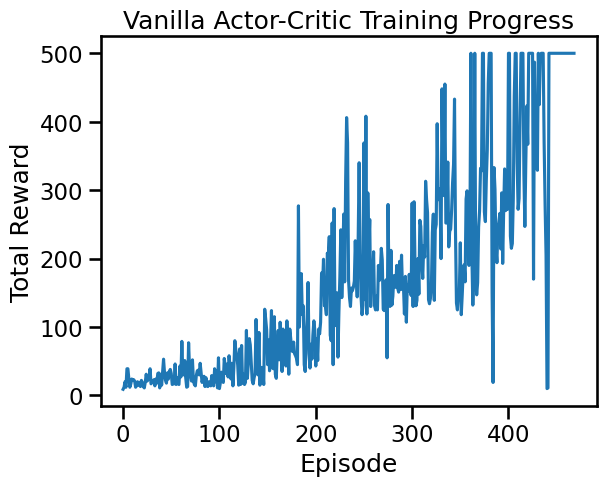

In [26]:
# train vanilla AC and plot rewards
env = gym.make(env_name)
print(device)
actor, critic, rewards = train_vanilla_ac(
    env=env,
    num_episodes=1000,#1000, max number of episodes
    alpha_theta=0.0001,#learning rate of actor/policy
    alpha_w=0.002,#learning rate of critic /value function
    gamma=0.99,
    max_reward=max_reward,#stops training after performing an episode with max_reward
    num_perfect_episodes=50 # number of episodes with max_reward needed to perform before stopping training
)
    
env.close()


plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Vanilla Actor-Critic Training Progress")
plt.show()

In [27]:
# test the trained vanilla AC
env = gym.make(env_name)
num_test_episode=1000
#test on many episodes to see avg reward per episodes
avg_rewards = avg_return_on_multiple_episodes(
    env,
    actor,
    num_test_episode=num_test_episode,
    max_episode_duration=500
)
env.close()
print(f"avg rewards over {num_test_episode} episodes is {avg_rewards}")
if avg_rewards>=0.8*max_reward:
    print(f"{env_name} solved!")
print(f"Avg reward is {avg_rewards/max_reward*100}% of max reward")
#try 1 episode and show the episode
run_and_display_episode(actor, env_name=env_name, video_title="trained_vanilla_agent")


avg rewards over 1000 episodes is 489.338
CartPole-v1 solved!
Avg reward is 97.8676% of max reward
Episode ran for 500 steps


In [28]:
# print out the (last) episode at which we should have stopped training
if (max(rewards)==max_reward):
    last_index = max(i for i, x in enumerate(rewards) if x == max_reward)
    print(last_index)
    print(rewards[last_index])

468
500.0


### Vanilla Actor-Critic Model with seperate NN (updates after each episode) Monte Carlo style

In [29]:
# Training function (Monte Carlo style)
def train_vanilla_mc_ac(env, num_episodes=1000, alpha_theta=0.001, alpha_w=0.002, gamma=0.99, max_reward=500, num_perfect_episodes=10):
    
    # Initialize networks
    policy_nn = ActorNetwork(observation_dim, num_actions)
    value_nn = CriticNetwork(observation_dim)
    
    # Optimizers
    theta_optimizer = optim.Adam(policy_nn.parameters(), lr=alpha_theta)
    w_optimizer = optim.Adam(value_nn.parameters(), lr=alpha_w)
    
    episode_rewards = []

    avg_reward = 0

    curr_num_perfect_episodes = 0 # number of episodes done with max_reward reached
    
    for episode in range(num_episodes):
        # Sample full episode
        states, actions, rewards, log_probs = sample_one_episode(env, policy_nn, max_episode_duration=500)
        
        # Compute discounted returns (G_t)
        G = []
        discounted_return = 0
        for r in reversed(rewards):
            discounted_return = r + gamma * discounted_return
            G.insert(0, discounted_return)
        G = torch.tensor(G, dtype=torch.float32).to(device)
        
        # Convert episode data to tensors
        state_tensors = torch.tensor(states[:-1], dtype=torch.float32).to(device)  # Exclude last state
        log_probs = torch.stack(log_probs).to(device)
        
        # Critic update: Fit V(s) to G_t
        w_optimizer.zero_grad()
        values = value_nn(state_tensors).squeeze()
        value_loss = torch.mean((G - values) ** 2) * 0.5  # 1/2 * (G - V)^2
        value_loss.backward()
        w_optimizer.step()
        
        # Actor update: Use advantage (G_t - V(s_t))
        theta_optimizer.zero_grad()
        advantages = (G - values.detach())  # Detach values to not backprop through critic
        actor_loss = -torch.mean(advantages * log_probs)  # - (G - V) * ln(pi)
        actor_loss.backward()
        theta_optimizer.step()
        
        total_reward = sum(rewards)
        episode_rewards.append(total_reward)


        """
        if episode % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:]) if episode > 0 else total_reward
            print(f"Episode {episode}, Total Reward: {total_reward}, Avg Reward (last 100): {avg_reward:.2f}")
        """
        if total_reward == max_reward:
            curr_num_perfect_episodes += 1
            if curr_num_perfect_episodes==num_perfect_episodes:
                print(f"\nStopping training at episode {episode} since agent has performed {curr_num_perfect_episodes} optimal episodes")
                return policy_nn, value_nn, episode_rewards
        
        if episode>=100 and episode%100==0:
            # only update every 100 episodes to not slow down training
            avg_reward = np.mean(episode_rewards[-100:]) if episode > 0 else total_reward
        print(f"\rEpisode {episode}/{num_episodes}, Total Reward: {total_reward}, Avg Reward (last 100): {avg_reward:.2f}, Num perfect episodes: {curr_num_perfect_episodes}/{num_perfect_episodes}", end="", flush=True)
    
    return policy_nn, value_nn, episode_rewards

Episode 533/1000, Total Reward: 500.0, Avg Reward (last 100): 371.39, Num perfect episodes: 49/50
Stopping training at episode 534 since agent has performed 50 optimal episodes


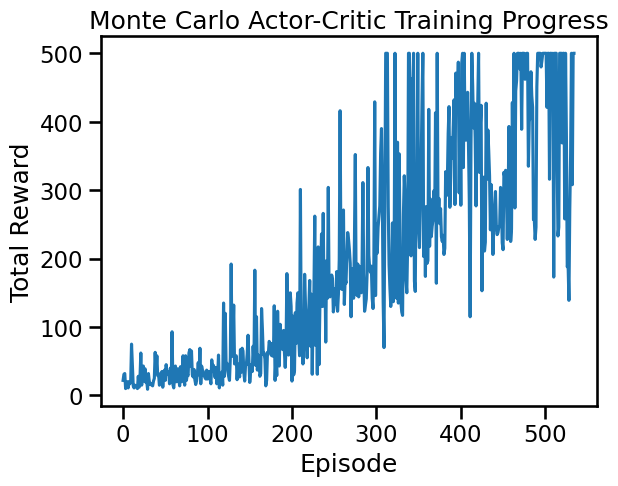

In [32]:
# train and plot rewards
env = gym.make(env_name)
actor, critic, rewards = train_vanilla_mc_ac(
    #env=env,
    #num_episodes=500,
    #alpha_theta=0.001,
    #alpha_w=0.002,
    #gamma=0.99
    env=env,
    num_episodes=1000,#1000, max number of episodes
    alpha_theta=0.001,#learning rate of actor/policy
    alpha_w=0.005,#learning rate of critic /value function
    gamma=0.99,
    max_reward=max_reward,#stops training after performing an episode with max_reward
    num_perfect_episodes=50 # number of episodes with max_reward needed to perform before stopping training
)
env.close()
    
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Monte Carlo Actor-Critic Training Progress")
plt.show()


In [34]:
# test the trained vanilla AC (MC)
env = gym.make(env_name)
num_test_episode=1000
avg_rewards = avg_return_on_multiple_episodes(
    env,
    actor,
    num_test_episode=num_test_episode,
    max_episode_duration=500
)
env.close()
print(f"avg rewards over {num_test_episode} episodes is {avg_rewards}")
if avg_rewards>=0.8*max_reward:
    print(f"{env_name} solved!")
print(f"Avg reward is {avg_rewards/max_reward*100}% of max reward")
run_and_display_episode(actor, env_name=env_name, video_title="trained_vanilla_MC_agent")

avg rewards over 1000 episodes is 485.876
CartPole-v1 solved!
Avg reward is 97.17519999999999% of max reward
Episode ran for 500 steps


# NOTES

In [ ]:
# TODO, DEBUG THE TRAIN FIUNCTION, NEED TO MAKE SURE PSEUDOCODE IS WELL FOLLOWED + THE SHAPES MUST MATCH
# COULD ADD COMMENTS TO EACH LINE OF CODE WITHT THE CORREESPONDING LINE OF PSEUDOCODE
# COULD TEST THE POLICY IN THE TRAINING LOOP FOR A FEW EPISODES, USING MODELTRAIN AND EVAL OF COURSE AND KEEPING TRACK OF THE AVG RETURN PER EPISODE (LIKE IN LAB6)

In [ ]:
# to fix problem of action probs shifting to 1, 0 or 0,1 for all states (so only 1 action is sampled), we need a counterforce to encourage exploration
# Without a counterforce, this becomes a feedback loop: the favored action gets reinforced, probabilities skew further, and exploration dies.
#Entropy Term: -beta * entropy penalizes low-entropy distributions (like [1.0, 0.0]), pushing action_probs toward a more balanced spread (e.g., [0.7, 0.3]).

#Exploration: Forces the agent to try both actions, allowing it to discover better policies (e.g., balancing the pole by alternating left and right).

"""
LOSSES:
optimizing π(A∣S,θ)
 to maximize future rewards, guided by δ
 Actor: Updates π using δ as a signal of action quality, plus entropy for exploration.



The critic’s job is to approximate the true value function Vπ(s)
. The TD error δ
 is the difference between the "expected" value (based on reward and next state) and the "actual" value.
value_loss = delta.pow(2)  # δ²
Minimizing δ2
 adjusts www
 to make v^(S,w)
 closer to r+γv^(S′,w), consistent with supervised regression


actor_loss = -log_prob * delta.detach() - entropy_beta * entropy
This isn’t a "loss" in the supervised sense (expected - actual), but an objective to maximize:
Policy Gradient Term: -log_prob * delta approximates −∇θJ(θ), where J(θ)J is the expected cumulative reward. 
Positive δ: Action was better than expected → increase π(A∣S,θ)\pi(A|S, \theta)\pi(A|S, \theta)
 (reduce -log_prob).

Negative δ: Action was worse → decrease π(A∣S,θ) (increase -log_prob).
We negate it because optimizers minimize loss, but we want to maximize reward.

Entropy Term: -entropy_beta * entropy encourages exploration.
Low entropy (e.g., [1, 0]) → small negative term → higher loss → penalizes determinism.
High entropy (e.g., [0.5, 0.5]) → larger negative term → lower loss → encourages diversity.



"""